In [1]:
!pip install -U unidecode underthesea --quiet
!pip install -U transformers==4.40.2 huggingface-hub==0.23.0 peft==0.10.0 --quiet
!pip install -U wandb --quiet

In [2]:
import re, json, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from unidecode import unidecode

from datasets import Dataset
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, EarlyStoppingCallback, Trainer,
    TrainerCallback, AutoConfig
)
import warnings
warnings.filterwarnings('ignore')
import wandb
wandb.login()

c:\Users\vtm-admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\vtm-admin\_netrc
wandb: Currently lo

True

# **1. Configuration**

In [ ]:
RANDOM_STATE = 42
# MODEL_NAME = "vinai/phobert-base"
MODEL_NAME = "vinai/phobert-large"
DATASET_PATH = "./datasets/Text_Emotion_2.csv"  # Raw dataset
OUTPUT_PATH = ""
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label mapping
LABEL_MAP = {0: "Tiêu cực", 1: "Trung lập", 2: "Tích cực"}
TARGET_LABELS = [0, 1, 2]

# Text cleaning
URL_REGEX     = re.compile(r'(https?://[^\s]+|www\.[^\s]+)')
EMAIL_REGEX   = re.compile(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+')
MENTION_REGEX = re.compile(r'@[A-Za-z0-9_]+')

# Keyword spam
SPAM_KEYWORDS = {"camp", "vé", "lazada", "tiki", "feedback", "checklegit"}

# Set random seeds
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

print(f"🚀 Using device: {DEVICE}")
print(f"📊 Target labels: {TARGET_LABELS}")

🚀 Using device: cuda
📊 Target labels: [0, 1, 2]


In [2]:
# 🧠 Tự phát hiện môi trường Kaggle
if "KAGGLE_URL_BASE" in os.environ or os.path.exists("/kaggle/working"):
    ROOT_ENV = "kaggle"
    MODEL_PATH = "./models/phobert_sentiment"
else:
    ROOT_ENV = "local"
    MODEL_PATH = "../serving/models/phobert_sentiment"

print(f"🌍 Running in {ROOT_ENV.upper()} environment")
print(f"📁 Model output path: {MODEL_PATH}")

🌍 Running in LOCAL environment
📁 Model output path: ../serving/models/phobert_sentiment


# **2. Data Loading & Initial Exploration**

In [4]:
print("=" * 50)
print("📂 LOADING DATASET")
print("=" * 50)

# Load raw dataset
df = pd.read_csv(DATASET_PATH)
print(f"📋 Total samples: {len(df)}")
print(f"📊 Columns: {list(df.columns)}")

📂 LOADING DATASET
📋 Total samples: 9801
📊 Columns: ['comment_text', 'labels']


In [5]:
# Basic info
print("\n🔍 Dataset Info:")
df.info()


🔍 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9801 entries, 0 to 9800
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  9801 non-null   object
 1   labels        9801 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 153.3+ KB


In [6]:
print("\n📈 Label Distribution (Before cleaning):")
if 'labels' in df.columns:
    print(df['labels'].value_counts().sort_index())
else:
    print("❌ 'labels' column not found!")


📈 Label Distribution (Before cleaning):
labels
0    3003
1    3359
2    3439
Name: count, dtype: int64


In [7]:
# Display sample data
print("\nSample Data:")
print(df.head(5))


Sample Data:
                                        comment_text  labels
0  Chắc cười ko ngậm đc mồm quá; toàn thủ phạm gâ...       2
1                        Bọn này chỉ hát hò múa thôi       0
2                                        Gai con mắt       0
3                       Đám gừng sỉ này diễn ghê quá       0
4                                         Trờiii ơiu       2


# **3. Data Cleaning Functions**

In [ ]:
def replace_url_with_token(match):
    url = match.group(0)
    try:
        domain = urlparse(url).netloc.lower()
    except:
        domain = url.lower()

    # YouTube
    if "youtube.com" in domain or "youtu.be" in domain:
        return " <YOUTUBE> "

    # Facebook (nếu chứa keyword spam trong link thì thành SPAMURL)
    elif "facebook.com" in domain or "fb.com" in domain:
        low_url = url.lower()
        if any(kw in low_url for kw in SPAM_KEYWORDS):
            return " <SPAMURL> "
        else:
            return " <FACEBOOK> "

    # Mặc định tất cả domain khác = SPAM
    else:
        return " <SPAMURL> "

def basic_clean(text):
    if not isinstance(text, str):
        return ""

    # Thay URL theo rule
    text = URL_REGEX.sub(replace_url_with_token, text)

    # Email, mention
    text = EMAIL_REGEX.sub(" <EMAIL> ", text)
    text = MENTION_REGEX.sub(" @user ", text)

    # Chuẩn hóa khoảng trắng
    return re.sub(r"\s+", " ", text).strip()

# **4. Data Cleaning & Preprocessing**

In [9]:
print("=" * 50)
print("🧹 CLEANING DATASET")
print("=" * 50)

# Clean the dataset
df_clean = df.dropna(subset=['comment_text', 'labels']).copy()
df_clean['labels'] = df_clean['labels'].astype(int)
df_clean = df_clean[df_clean['labels'].isin(TARGET_LABELS)].reset_index(drop=True)

print(f"📋 After filtering: {len(df_clean)} samples")
print(f"📊 Label distribution after filtering:")
print(df_clean['labels'].value_counts().sort_index())

🧹 CLEANING DATASET
📋 After filtering: 9801 samples
📊 Label distribution after filtering:
labels
0    3003
1    3359
2    3439
Name: count, dtype: int64


In [10]:
# Apply basic cleaning
df_clean['comment_text_clean'] = df_clean['comment_text'].apply(basic_clean)

In [11]:
# Lấy vài sample có gắn <SPAMURL>
sample_spam = df_clean[df_clean['comment_text_clean'].str.contains("<SPAMURL>")].sample(10)

for i, row in sample_spam.iterrows():
    print(f"✅ {row['comment_text_clean']}")


✅ <SPAMURL> Đại tiệc sinh nhật 789BET với vô vàn nhiều phần quà hấp dẫn và các sự kiện hot nhất trong tháng 9. Tích vé quay xe nhận ngay xe MERCEDES-BENZ C200 Avan. tga rde; SH 125i; Ipho.ne 16 Pro max... Đạt mốc siêu nhanh - nhận n gay 1 cây vàng. Đặc biệt có sự góp mặt của ca sĩ Lâ m Ch ấn H.uy khuấy độ.ng không khí sự kiện. Đ.ừng chần chừ; tích vé càng nhiều – cơ hội trúng càng cao! 892 84 u2ort
✅ Vay nhanh 1 TRIỆU - 30 TRIỆU - 1 TỶ (chấp nhận hồ sơ không vay được ngân hàng) Đăng ký vay ngay tại đây: <SPAMURL> Vay Tiền Nhanh Bằng Đăng Kí/ Cà vẹt Xe Máy - Ô tô Địa chỉ: F88 505 Ngọc Hồi; Thanh Trì; Hà Nội ☎️Call 024.7303.9388
✅ Dép bánh mì kẹp ngón cao 3 cm siêu xinh <SPAMURL>
✅ Nạp USDT liền tay – Nạp chủ nhật tặng thêm 8%; Nhận ngay 1% thưởng; không giới hạn – Chơi lớn cùng 789BET; tải app đăng ký nhận ngay 50K; nạp đầu thưởng 188K bắn cá nổ hũ; Thăng cấp VIP mỗi lần thưởng thêm 188K; mỗi ngày phát 18;789 hồng bao may mắn đến các hội viên.. hãy tham gia ngay kẻo bỏ lở <SPAMURL>
✅ Kệ

In [ ]:
tests = [
    "Mua ngay https://shopee.vn/abc123",
    "Xem video https://www.youtube.com/watch?v=abc",
    "Truy cập https://vnexpress.net/tin-tuc",
    "mình nhận camp vé giá rẻ",
    "Phim này rất hay và cảm động!",
    "Dịch vụ tệ quá, tôi rất thất vọng",
    "Sản phẩm bình thường, không có gì đặc biệt",
    "Film nay rat hay va cam dong!", # No accent version
    "mình nhận camp vé",
    "Dở tệ, phí thời gian.",
    "https://shopee.vn/%E1%BB%90p-L%C6%B0ng-Cho-Xiaomi-Redmi-Note-13-11-12-Pro-Plus-5G-Turbo-3-12S-11S-10S-10-9S-9-Pro-Redmi-12-13-12C-10C-13C-Ng%E1%BB%99-ngh%C4%A9nh-C%E1%BA%B7p-%C4%90%C3%B4i-%C4%90i%E1%BB%87n-H%E1%BB%8Da-Ti%E1%BA%BFt-Xe-M%C3%A1y-Silicon-M%E1%BB%9D-B%C3%ACa-M%E1%BB%81m-i.1005456513.26104563210?sp_atk=7975f1af-d972-4ffb-8ee8-ffbe9a161069&xptdk=7975f1af-d972-4ffb-8ee8-ffbe9a161069"
]

for t in tests:
    print(t, "→", basic_clean(t))

Mua ngay https://shopee.vn/abc123 → Mua ngay <SPAMURL>
Xem video https://www.youtube.com/watch?v=abc → Xem video <YOUTUBE>
Truy cập https://vnexpress.net/tin-tuc → Truy cập <SPAMURL>
mình nhận camp vé giá rẻ → mình nhận camp vé giá rẻ
Phim này rất hay và cảm động! → Phim này rất hay và cảm động!
Dịch vụ tệ quá, tôi rất thất vọng → Dịch vụ tệ quá, tôi rất thất vọng
Sản phẩm bình thường, không có gì đặc biệt → Sản phẩm bình thường, không có gì đặc biệt
Film nay rat hay va cam dong! → Film nay rat hay va cam dong!
mình nhận camp vé → mình nhận camp vé
Dở tệ, phí thời gian. → Dở tệ, phí thời gian.
https://shopee.vn/%E1%BB%90p-L%C6%B0ng-Cho-Xiaomi-Redmi-Note-13-11-12-Pro-Plus-5G-Turbo-3-12S-11S-10S-10-9S-9-Pro-Redmi-12-13-12C-10C-13C-Ng%E1%BB%99-ngh%C4%A9nh-C%E1%BA%B7p-%C4%90%C3%B4i-%C4%90i%E1%BB%87n-H%E1%BB%8Da-Ti%E1%BA%BFt-Xe-M%C3%A1y-Silicon-M%E1%BB%9D-B%C3%ACa-M%E1%BB%81m-i.1005456513.26104563210?sp_atk=7975f1af-d972-4ffb-8ee8-ffbe9a161069&xptdk=7975f1af-d972-4ffb-8ee8-ffbe9a161069 → <S

# **5. Train/Validation/Test Split**

In [ ]:
print("=" * 50)
print("✂️ SPLITTING DATASET")
print("=" * 50)

# Split dataset BEFORE oversampling to prevent data leakage
train_df, temp_df = train_test_split(
    df_clean,
    test_size=0.2,
    stratify=df_clean['labels'],
    random_state=RANDOM_STATE
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['labels'],
    random_state=RANDOM_STATE
)

print(f"📊 Dataset Splits:")
print(f"  Train: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

print(f"\n📈 Label Distribution per Split:")
print("Train:")
print(train_df['labels'].value_counts().sort_index())
print("\nValidation:")
print(val_df['labels'].value_counts().sort_index())
print("\nTest:")
print(test_df['labels'].value_counts().sort_index())

✂️ SPLITTING DATASET
📊 Dataset Splits:
  Train: 7840 samples
  Validation: 980 samples
  Test: 981 samples

📈 Label Distribution per Split:
Train:
labels
0    2402
1    2687
2    2751
Name: count, dtype: int64

Validation:
labels
0    300
1    336
2    344
Name: count, dtype: int64

Test:
labels
0    301
1    336
2    344
Name: count, dtype: int64


# **8. Prepare Datasets for Training**

In [14]:
print("=" * 50)
print("🔧 PREPARING DATASETS FOR TRAINING")
print("=" * 50)

# Prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✅ Loaded tokenizer: {MODEL_NAME}")

🔧 PREPARING DATASETS FOR TRAINING


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Loaded tokenizer: vinai/phobert-large


In [ ]:
def word_segment_vietnamese(text):
    """Vietnamese word segmentation for PhoBERT"""
    try:
        return word_tokenize(text, format="text").replace(" ", "_")
    except:
        return text.replace(" ", "_")

def tokenize_batch(batch):
    """Tokenize batch of texts with Vietnamese word segmentation"""
    segmented_texts = [word_segment_vietnamese(text) for text in batch['comment_text']]

    return tokenizer(
        segmented_texts,
        truncation=True,
        max_length=256,
        padding=False  # Dynamic padding will be handled by Trainer
    )

In [ ]:
# Create HuggingFace Datasets
print("🔄 Creating HuggingFace Datasets...")

# Luôn dùng comment_text_clean và rename thành comment_text để thống nhất
train_dataset = Dataset.from_pandas(
    train_df[['comment_text_clean', 'labels']].rename(columns={'comment_text_clean': 'comment_text'}),
    preserve_index=False
)

val_dataset = Dataset.from_pandas(
    val_df[['comment_text_clean', 'labels']].rename(columns={'comment_text_clean': 'comment_text'}),
    preserve_index=False
)

test_dataset = Dataset.from_pandas(
    test_df[['comment_text_clean', 'labels']].rename(columns={'comment_text_clean': 'comment_text'}),
    preserve_index=False
)

# Apply tokenization
print("🔄 Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_batch, batched=True)
val_dataset = val_dataset.map(tokenize_batch, batched=True)
test_dataset = test_dataset.map(tokenize_batch, batched=True)

print("✅ Datasets tokenized successfully!")

🔄 Creating HuggingFace Datasets...
🔄 Tokenizing datasets...


Map:   0%|          | 0/7840 [00:00<?, ? examples/s]

Map:   0%|          | 0/980 [00:00<?, ? examples/s]

Map:   0%|          | 0/981 [00:00<?, ? examples/s]

✅ Datasets tokenized successfully!


# **9. Model Setup & Training**

In [17]:
print("=" * 60)
print("🤖 MODEL CONFIGURATION")
print("=" * 60)

# config = AutoConfig.from_pretrained(MODEL_NAME)
# config.num_labels = 3
# config.hidden_dropout_prob = 0.1
# config.attention_probs_dropout_prob = 0.1

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    hidden_dropout_prob=0.15,
    attention_probs_dropout_prob=0.15
)

🤖 MODEL CONFIGURATION


In [18]:
print("=" * 50)
print("🤖 SETTING UP MODEL")
print("=" * 50)

# Load PhoBERT model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    # num_labels=len(TARGET_LABELS)
    config=config
)
model.to(DEVICE)
print(f"✅ Loaded model: {MODEL_NAME}")
print(f"📊 Model parameters: {model.num_parameters():,}")

🤖 SETTING UP MODEL


pytorch_model.bin:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model: vinai/phobert-large
📊 Model parameters: 369,166,339


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    do_train=True,
    do_eval=True,

    learning_rate=8e-6,              # quay về LR ổn định
    num_train_epochs=20,             # đủ lâu để hội tụ
    warmup_ratio=0.2,
    weight_decay=0.2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,

    # theo dõi & chọn theo macro-F1
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=100,             # THÊM MỚI
    save_steps=100,             # THÊM MỚI
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    save_total_limit=2,

    # scheduler mượt hơn
    lr_scheduler_type="cosine",

    # ổn định/hiệu năng
    fp16=True,
    max_grad_norm=0.5,
    logging_steps=50,
    report_to="wandb",
    seed=RANDOM_STATE,
    dataloader_num_workers=2,
    label_smoothing_factor=0.1,
    run_name="phobert_sentiment_v1", # tên hiển thị trên dashboard wandb
)

**Thiết lập một `EarlyStoppingCallback` để dừng huấn luyện sớm nếu model không cải thiện trên tập validation:**

- `early_stopping_patience = 3`: nếu 3 lần đánh giá liên tiếp không thấy accuracy tăng thì dừng.
- `early_stopping_threshold = 0.0`: yêu cầu tăng ít nhất một lượng dương (bất kỳ) mới tính là cải thiện.

> **Chú ý:** truyền `tokenizer=tokenizer` để `Trainer` tự động dùng padding động khi tạo batch.


In [20]:
# Early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=5e-4
)

In [ ]:
# Metrics computation
def compute_metrics(eval_pred):
    """Compute accuracy and F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted
    }

In [22]:
class TrainEvalLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # if "loss" in logs:
            #     print(f"Step {state.global_step} - Train loss: {logs['loss']:.4f}")
            if "eval_loss" in logs:
                print(f"Step {state.global_step} - Eval loss: {logs['eval_loss']:.4f}")

In [ ]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping, TrainEvalLossCallback],
    # rdrop_alpha=2.0
)

print("✅ Trainer setup complete!")

✅ Trainer setup complete!


In [ ]:
wandb.init(project="phobert_sentiment", name="run_kaggle_v1", config={
    "epochs": 3,
    "lr": 2e-5,
    "batch_size": 16
})

print("✅ wandb setup complete!")

# **10. Training**

In [ ]:
print("=" * 50)
print("🚀 STARTING TRAINING")
print("=" * 50)

# Start training
trainer_result = trainer.train()
wandb.finish()

print("✅ Training completed!")
print(f"🏆 Best validation f1_macro: {trainer.state.best_metric:.4f}")

🚀 STARTING TRAINING


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
100,1.099300,1.097951,0.372449,0.313238,0.310935
200,1.095000,1.090520,0.397959,0.314727,0.325882
300,1.051200,1.037076,0.487755,0.488381,0.488487
400,0.945500,0.917291,0.579592,0.565987,0.562302
500,0.881900,0.883372,0.618367,0.614033,0.611516
600,0.817800,0.799629,0.703061,0.706012,0.703157
700,0.788900,0.791073,0.697959,0.695443,0.693130
800,0.730300,0.771763,0.718367,0.718358,0.716175
900,0.688800,0.743590,0.741837,0.741851,0.739599
1000,0.662100,0.744219,0.754082,0.755589,0.753526


Step 100 - Eval loss: 1.0980
Step 200 - Eval loss: 1.0905
Step 300 - Eval loss: 1.0371
Step 400 - Eval loss: 0.9173
Step 500 - Eval loss: 0.8834
Step 600 - Eval loss: 0.7996
Step 700 - Eval loss: 0.7911
Step 800 - Eval loss: 0.7718
Step 900 - Eval loss: 0.7436
Step 1000 - Eval loss: 0.7442
Step 1100 - Eval loss: 0.7286
Step 1200 - Eval loss: 0.7293
Step 1300 - Eval loss: 0.7537
Step 1400 - Eval loss: 0.7385
Step 1500 - Eval loss: 0.7491
Step 1600 - Eval loss: 0.7549
Step 1700 - Eval loss: 0.7479
Step 1800 - Eval loss: 0.7466
✅ Training completed!
🏆 Best validation f1_macro: 0.7724


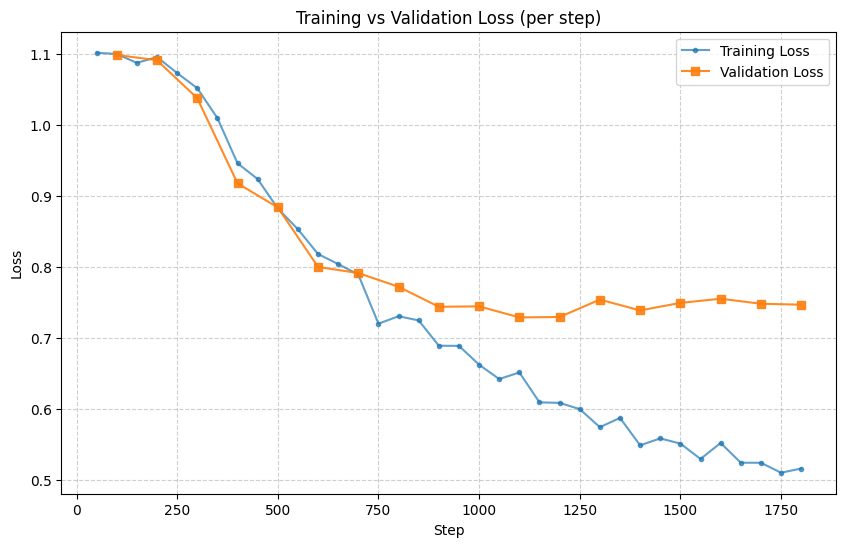

In [29]:
# Lấy toàn bộ log
logs = pd.DataFrame(trainer.state.log_history)

# Training loss theo step
df_train = logs[(logs["loss"].notna()) & (logs["epoch"].notna())][["step", "epoch", "loss"]]

# Validation loss theo step (có nếu evaluation_strategy="steps")
df_eval = logs[logs["eval_loss"].notna()][["step", "epoch", "eval_loss"]]

# Vẽ
plt.figure(figsize=(10,6))

plt.plot(df_train["step"], df_train["loss"], marker=".", alpha=0.7, label="Training Loss")
plt.plot(df_eval["step"], df_eval["eval_loss"], marker="s", alpha=0.9, label="Validation Loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (per step)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [30]:
# Save model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(training_args.output_dir)
print(f"💾 Model saved to: {training_args.output_dir}")

💾 Model saved to: ./models/phobert_sentiment


# **11. Model Evaluation**

📊 EVALUATING MODEL


🎯 Test Results:
  Accuracy: 0.7768
  F1-Macro: 0.7792
  F1-Weighted: 0.7770

📋 Detailed Classification Report:
              precision    recall  f1-score   support

    Tiêu cực     0.8652    0.8106    0.8370       301
   Trung lập     0.7781    0.6994    0.7367       336
    Tích cực     0.7128    0.8227    0.7638       344

    accuracy                         0.7768       981
   macro avg     0.7854    0.7776    0.7792       981
weighted avg     0.7820    0.7768    0.7770       981



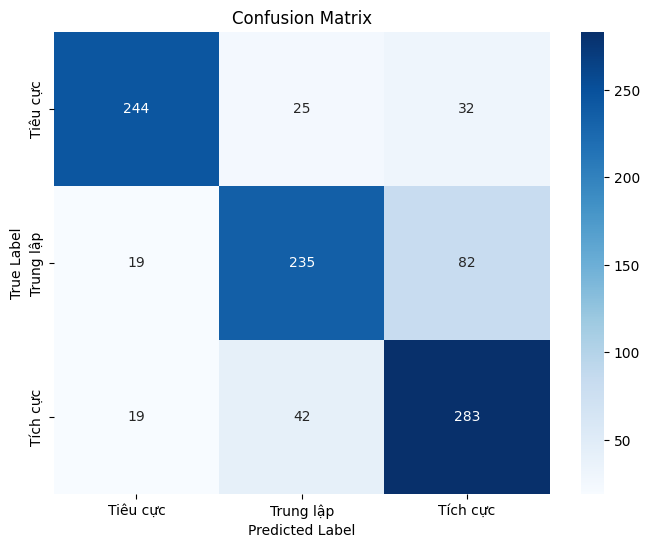

In [ ]:
print("=" * 50)
print("📊 EVALUATING MODEL")
print("=" * 50)

# Evaluate on test set
test_results = trainer.predict(test_dataset=test_dataset)
test_predictions = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_f1_macro = f1_score(test_labels, test_predictions, average='macro')
test_f1_weighted = f1_score(test_labels, test_predictions, average='weighted')

print(f"🎯 Test Results:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1-Macro: {test_f1_macro:.4f}")
print(f"  F1-Weighted: {test_f1_weighted:.4f}")

# Detailed classification report
class_names = [LABEL_MAP[i] for i in TARGET_LABELS]
print(f"\n📋 Detailed Classification Report:")
print(classification_report(
    test_labels,
    test_predictions,
    target_names=class_names,
    digits=4
))

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **12. Model Testing**

In [ ]:
print("=" * 50)
print("🧪 SETTING UP INFERENCE FUNCTION")
print("=" * 50)

def predict_sentiment(text, model_dir=MODEL_PATH):
    """Predict sentiment of a Vietnamese text"""

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model.to(DEVICE)
    model.eval()

    # Preprocess text
    cleaned_text = basic_clean(text)
    segmented_text = word_segment_vietnamese(cleaned_text)

    # Tokenize
    inputs = tokenizer(
        segmented_text,
        return_tensors="pt",
        truncation=True,
        max_length=256
    ).to(DEVICE)

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = F.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Format results
    results = {
        "original_text": text,
        "cleaned_text": cleaned_text,
        "segmented_text": segmented_text,
        "predicted_label": predicted_class,
        "predicted_class": LABEL_MAP[predicted_class],
        "probabilities": {
            LABEL_MAP[i]: prob.item()
            for i, prob in enumerate(probabilities.squeeze())
        }
    }

    return results

🧪 SETTING UP INFERENCE FUNCTION


In [ ]:
# Test the inference function
test_texts = [
    "Phim này rất hay và cảm động!",
    "Dịch vụ tệ quá, tôi rất thất vọng",
    "Sản phẩm bình thường, không có gì đặc biệt",
    "Film nay rat hay va cam dong!", # No accent version
    "mình nhận camp vé",
    "Dở tệ, phí thời gian.",
    "https://shopee.vn/%E1%BB%90p-L%C6%B0ng-Cho-Xiaomi-Redmi-Note-13-11-12-Pro-Plus-5G-Turbo-3-12S-11S-10S-1S0-9-9-Pro-Redmi-12-13-12C-10C-13C-Ng%E1%BB%99-ngh%C4%A9nh-C%E1%BA%B7p-%C4%90%C3%B4i-%C4%90i%E1%BB%87n-H%E1%BB%8Da-Ti%E1%BA%BFt-Xe-M%C3%A1y-Silicon-M%E1%BB%9D-B%C3%ACa-M%E1%BB%81m-i.1005456513.26104563210?sp_atk=7975f1af-d972-4ffb-8ee8-ffbe9a161069&xptdk=7975f1af-d972-4ffb-8ee8-ffbe9a161069"
]

print("🔍 Testing Inference Function:")
for i, test_text in enumerate(test_texts, 1):
    print(f"\nTest {i}:")
    result = predict_sentiment(test_text, MODEL_PATH)
    print(f"  Input: {result['original_text']}")
    print(f"  Prediction: {result['predicted_class']}")
    print(f"  Confidence: {result['probabilities'][result['predicted_class']]:.3f}")

print("=" * 50)
print("✅ TRAINING PIPELINE COMPLETED!")
print("=" * 50)

print(f"""
🎉 Summary:
  📊 Final training data: {len(train_df)} samples
  🏆 Best validation accuracy: {trainer.state.best_metric:.4f}
  🎯 Test accuracy: {test_accuracy:.4f}
  💾 Model saved to: {training_args.output_dir}""")

🔍 Testing Inference Function:

Test 1:
  Input: Phim này rất hay và cảm động!
  Prediction: Tích cực
  Confidence: 0.967

Test 2:
  Input: Dịch vụ tệ quá, tôi rất thất vọng
  Prediction: Tiêu cực
  Confidence: 0.951

Test 3:
  Input: Sản phẩm bình thường, không có gì đặc biệt
  Prediction: Trung lập
  Confidence: 0.536

Test 4:
  Input: Film nay rat hay va cam dong!
  Prediction: Tiêu cực
  Confidence: 0.695

Test 5:
  Input: mình nhận camp vé
  Prediction: Tiêu cực
  Confidence: 0.953

Test 6:
  Input: Dở tệ, phí thời gian.
  Prediction: Tiêu cực
  Confidence: 0.953

Test 7:
  Input: https://shopee.vn/%E1%BB%90p-L%C6%B0ng-Cho-Xiaomi-Redmi-Note-13-11-12-Pro-Plus-5G-Turbo-3-12S-11S-10S-1S0-9-9-Pro-Redmi-12-13-12C-10C-13C-Ng%E1%BB%99-ngh%C4%A9nh-C%E1%BA%B7p-%C4%90%C3%B4i-%C4%90i%E1%BB%87n-H%E1%BB%8Da-Ti%E1%BA%BFt-Xe-M%C3%A1y-Silicon-M%E1%BB%9D-B%C3%ACa-M%E1%BB%81m-i.1005456513.26104563210?sp_atk=7975f1af-d972-4ffb-8ee8-ffbe9a161069&xptdk=7975f1af-d972-4ffb-8ee8-ffbe9a161069
  Prediction:

In [36]:
for text in test_texts:
    print(text[:60], "→", basic_clean(text))


Phim này rất hay và cảm động! → Phim này rất hay và cảm động!
Dịch vụ tệ quá, tôi rất thất vọng → Dịch vụ tệ quá, tôi rất thất vọng
Sản phẩm bình thường, không có gì đặc biệt → Sản phẩm bình thường, không có gì đặc biệt
Film nay rat hay va cam dong! → Film nay rat hay va cam dong!
mình nhận camp vé → mình nhận camp vé
Dở tệ, phí thời gian. → Dở tệ, phí thời gian.
https://shopee.vn/%E1%BB%90p-L%C6%B0ng-Cho-Xiaomi-Redmi-Note → <SPAMURL>


In [ ]:
# Dùng nếu train trên kaggle / Nén file zip -> download -> giải nén vào thư mục serving

# import shutil
# shutil.make_archive('/kaggle/working/models', 'zip', '/kaggle/working/models')

'/kaggle/working/output.zip'